# Module 4 - Lesson 2: Scaling and Normalization

## Making Features Comparable for Machine Learning

Welcome to Lesson 2! This notebook will teach you one of the most critical but often misunderstood aspects of data preparation: scaling and normalization. Get this wrong, and even the best model will perform poorly. Get it right, and you'll see immediate improvements in model performance.

### What You'll Learn:
- Why scaling matters for different algorithms
- Four main scaling techniques and when to use each
- How to avoid data leakage when scaling
- Common mistakes and how to avoid them
- Production considerations for scaling

### Why This Matters:
Imagine you're predicting house prices using age (0-100 years) and price ($100,000-$1,000,000). Without scaling, the price feature will dominate any distance-based calculation simply because its numbers are bigger - not because it's more important!

## Setup: Import Required Libraries

Let's start by importing the libraries we'll need for this lesson:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Set display options for better output
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Understanding the Scaling Problem

### Why Features Need Scaling

Different features often have vastly different scales. This causes problems because:
1. **Distance-based algorithms** (KNN, SVM, K-Means) calculate distances between points
2. **Gradient descent** converges much slower with unscaled features
3. **Regularization** penalizes large coefficients unfairly if features aren't scaled

Let's see this problem in action:

In [2]:
# Create sample data with different scales
np.random.seed(42)
n_samples = 1000

# Features with very different scales
df = pd.DataFrame({
    'age': np.random.uniform(18, 80, n_samples),           # Range: ~60
    'income': np.random.uniform(20000, 200000, n_samples), # Range: ~180,000
    'credit_score': np.random.uniform(300, 850, n_samples), # Range: ~550
    'num_purchases': np.random.poisson(5, n_samples),      # Range: ~0-15
    'years_customer': np.random.uniform(0, 20, n_samples)   # Range: ~20
})

print("Data with different scales:")
print(df.describe())
print("\nScale differences:")
print(f"Age range: {df['age'].max() - df['age'].min():.0f}")
print(f"Income range: {df['income'].max() - df['income'].min():.0f}")
print(f"Income range is {(df['income'].max() - df['income'].min()) / (df['age'].max() - df['age'].min()):.0f}x larger than age range!")

Data with different scales:
             age       income  credit_score  num_purchases  years_customer
count  1000.0000    1000.0000     1000.0000      1000.0000       1000.0000
mean     48.3959  111263.1149      576.3231         4.8990         10.0362
std      18.1125   52594.1808      159.8708         2.0389          5.5849
min      18.2872   20579.2874      300.0064         0.0000          0.0011
25%      32.6303   63393.3688      443.7430         3.0000          5.3851
50%      48.8021  113372.1032      575.3377         5.0000         10.0914
75%      64.1478  156883.7103      717.5069         6.0000         14.7191
max      79.9825  199894.4706      848.8015        12.0000         19.9723

Scale differences:
Age range: 62
Income range: 179315
Income range is 2906x larger than age range!


### The Distance Problem Visualized

Let's see how unscaled features affect distance calculations:

In [3]:
# Calculate distance between two customers
customer1 = df.iloc[0][['age', 'income']].values
customer2 = df.iloc[1][['age', 'income']].values

# Euclidean distance
distance = np.sqrt(np.sum((customer1 - customer2)**2))

# Contribution of each feature to distance
age_contribution = (customer1[0] - customer2[0])**2
income_contribution = (customer1[1] - customer2[1])**2

print("Customer 1:", customer1)
print("Customer 2:", customer2)
print(f"\nTotal distance: {distance:.2f}")
print(f"Age contribution: {age_contribution:.2f} ({age_contribution/distance**2*100:.1f}%)")
print(f"Income contribution: {income_contribution:.2f} ({income_contribution/distance**2*100:.1f}%)")
print("\n⚠️ Income dominates the distance calculation even though it might not be more important!")

Customer 1: [4.12214874e+01 5.33239272e+04]
Customer 2: [7.69442870e+01 1.17542171e+05]

Total distance: 64218.25
Age contribution: 1276.12 (0.0%)
Income contribution: 4123982777.31 (100.0%)

⚠️ Income dominates the distance calculation even though it might not be more important!


### Impact on Different Algorithms

Not all algorithms are equally affected by scaling:

In [4]:
# Create a classification dataset
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=300, n_features=2, n_informative=2, 
                          n_redundant=0, random_state=42)

# Scale one feature to be much larger
X[:, 1] = X[:, 1] * 1000

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Test different algorithms
algorithms = {
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'SVM': SVC(kernel='rbf'),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42)
}

print("Performance WITHOUT scaling:")
print("-" * 40)
for name, model in algorithms.items():
    model.fit(X_train, y_train)
    score = accuracy_score(y_test, model.predict(X_test))
    print(f"{name:20s}: {score:.3f}")

# Now with scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nPerformance WITH scaling:")
print("-" * 40)
for name, model in algorithms.items():
    model.fit(X_train_scaled, y_train)
    score = accuracy_score(y_test, model.predict(X_test_scaled))
    print(f"{name:20s}: {score:.3f}")
    
print("\n📝 Note: KNN and SVM improve dramatically with scaling!")
print("📝 Decision Trees don't care about scaling (they use splits, not distances)")

Performance WITHOUT scaling:
----------------------------------------
KNN                 : 0.556
SVM                 : 0.578
Decision Tree       : 0.956
Logistic Regression : 0.900

Performance WITH scaling:
----------------------------------------
KNN                 : 0.956
SVM                 : 0.956
Decision Tree       : 0.956
Logistic Regression : 0.900

📝 Note: KNN and SVM improve dramatically with scaling!
📝 Decision Trees don't care about scaling (they use splits, not distances)


## 2. StandardScaler (Z-Score Normalization)

### How StandardScaler Works

StandardScaler transforms features to have:
- **Mean = 0** (centered)
- **Standard deviation = 1** (scaled)

Formula: `z = (x - μ) / σ`

This is the most common scaling method and works well when your data is approximately normally distributed.

In [5]:
# Create sample data
np.random.seed(42)
data = pd.DataFrame({
    'normal_feature': np.random.normal(100, 15, 1000),      # Normal distribution
    'skewed_feature': np.random.exponential(10, 1000),      # Skewed distribution
    'uniform_feature': np.random.uniform(0, 100, 1000)      # Uniform distribution
})

print("Original data statistics:")
print(data.describe())

Original data statistics:
       normal_feature  skewed_feature  uniform_feature
count       1000.0000       1000.0000        1000.0000
mean         100.2900         10.0799          49.4495
std           14.6882         10.0299          28.8920
min           51.3810          0.0322           0.0012
25%           90.2861          2.8395          25.6524
50%          100.3795          7.2593          49.1711
75%          109.7192         13.7168          73.8629
max          157.7910         74.4172          99.7821


### Applying StandardScaler

In [6]:
from sklearn.preprocessing import StandardScaler

# Initialize and fit the scaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
scaled_df = pd.DataFrame(scaled_data, columns=data.columns)

print("After StandardScaler:")
print(scaled_df.describe())
print("\n✅ Notice: mean ≈ 0, std ≈ 1 for all features")

# Store the parameters for later use
print("\nScaler parameters (important for production!):")
print(f"Means: {scaler.mean_}")
print(f"Standard deviations: {scaler.scale_}")

After StandardScaler:
       normal_feature  skewed_feature  uniform_feature
count      1.0000e+03      1.0000e+03       1.0000e+03
mean       1.2523e-16      1.8474e-16      -1.9895e-16
std        1.0005e+00      1.0005e+00       1.0005e+00
min       -3.3315e+00     -1.0023e+00      -1.7123e+00
25%       -6.8142e-01     -7.2224e-01      -8.2407e-01
50%        6.0983e-03     -2.8136e-01      -9.6420e-03
75%        6.4228e-01      3.6280e-01       8.4541e-01
max        3.9167e+00      6.4178e+00       1.7430e+00

✅ Notice: mean ≈ 0, std ≈ 1 for all features

Scaler parameters (important for production!):
Means: [100.28998084  10.07985934  49.44949862]
Standard deviations: [14.68089312 10.02486889 28.87751747]


### Visualizing StandardScaler Effect

Let's see how StandardScaler transforms different distributions:

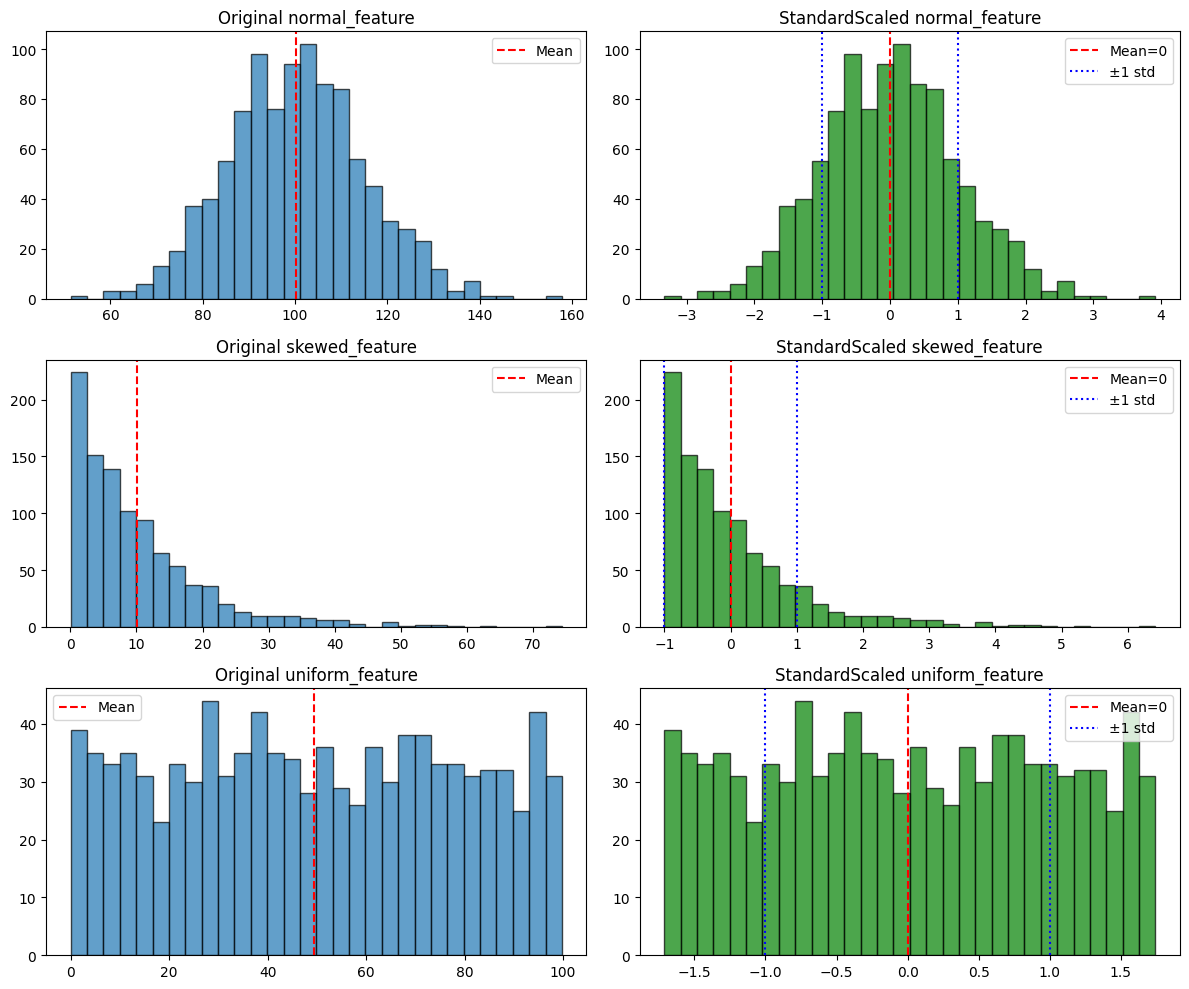

📝 Key observations:
- Shape of distribution doesn't change
- All features now centered at 0
- Most values between -3 and 3
- Outliers still remain as outliers


In [7]:
fig, axes = plt.subplots(3, 2, figsize=(12, 10))

for idx, col in enumerate(data.columns):
    # Original distribution
    axes[idx, 0].hist(data[col], bins=30, edgecolor='black', alpha=0.7)
    axes[idx, 0].set_title(f'Original {col}')
    axes[idx, 0].axvline(data[col].mean(), color='red', linestyle='--', label='Mean')
    axes[idx, 0].legend()
    
    # Scaled distribution
    axes[idx, 1].hist(scaled_df[col], bins=30, edgecolor='black', alpha=0.7, color='green')
    axes[idx, 1].set_title(f'StandardScaled {col}')
    axes[idx, 1].axvline(0, color='red', linestyle='--', label='Mean=0')
    axes[idx, 1].axvline(-1, color='blue', linestyle=':', label='±1 std')
    axes[idx, 1].axvline(1, color='blue', linestyle=':')
    axes[idx, 1].legend()

plt.tight_layout()
plt.show()

print("📝 Key observations:")
print("- Shape of distribution doesn't change")
print("- All features now centered at 0")
print("- Most values between -3 and 3")
print("- Outliers still remain as outliers")

### When to Use StandardScaler

**Use StandardScaler when:**
- Your features are approximately normally distributed
- You're using algorithms that assume normal distribution (e.g., Linear Regression, Logistic Regression)
- You're using distance-based algorithms (KNN, SVM, K-Means)
- You want to preserve outliers (they remain as extreme values)

**Don't use when:**
- Your data has significant outliers that you don't want to preserve
- You need values in a specific range (use MinMaxScaler instead)

## 3. MinMaxScaler (Min-Max Normalization)

### How MinMaxScaler Works

MinMaxScaler transforms features to a specific range, typically [0, 1]:

Formula: `x_scaled = (x - min) / (max - min)`

This preserves the original distribution shape while ensuring all values fall within the specified range.

In [8]:
# Create sample data with outliers
np.random.seed(42)
data_mm = pd.DataFrame({
    'feature1': np.concatenate([np.random.normal(50, 10, 950), 
                                np.random.uniform(100, 150, 50)]),  # With outliers
    'feature2': np.random.uniform(0, 100, 1000),
    'feature3': np.random.exponential(20, 1000)
})

print("Original data ranges:")
for col in data_mm.columns:
    print(f"{col}: [{data_mm[col].min():.2f}, {data_mm[col].max():.2f}]")

Original data ranges:
feature1: [17.59, 149.33]
feature2: [0.32, 99.94]
feature3: [0.00, 122.58]


### Applying MinMaxScaler

In [9]:
from sklearn.preprocessing import MinMaxScaler

# Default range [0, 1]
scaler_01 = MinMaxScaler()
scaled_01 = scaler_01.fit_transform(data_mm)
scaled_01_df = pd.DataFrame(scaled_01, columns=data_mm.columns)

# Custom range [-1, 1]
scaler_11 = MinMaxScaler(feature_range=(-1, 1))
scaled_11 = scaler_11.fit_transform(data_mm)
scaled_11_df = pd.DataFrame(scaled_11, columns=data_mm.columns)

print("After MinMaxScaler [0, 1]:")
for col in scaled_01_df.columns:
    print(f"{col}: [{scaled_01_df[col].min():.2f}, {scaled_01_df[col].max():.2f}]")

print("\nAfter MinMaxScaler [-1, 1]:")
for col in scaled_11_df.columns:
    print(f"{col}: [{scaled_11_df[col].min():.2f}, {scaled_11_df[col].max():.2f}]")

After MinMaxScaler [0, 1]:
feature1: [0.00, 1.00]
feature2: [0.00, 1.00]
feature3: [0.00, 1.00]

After MinMaxScaler [-1, 1]:
feature1: [-1.00, 1.00]
feature2: [-1.00, 1.00]
feature3: [-1.00, 1.00]


### Visualizing MinMaxScaler

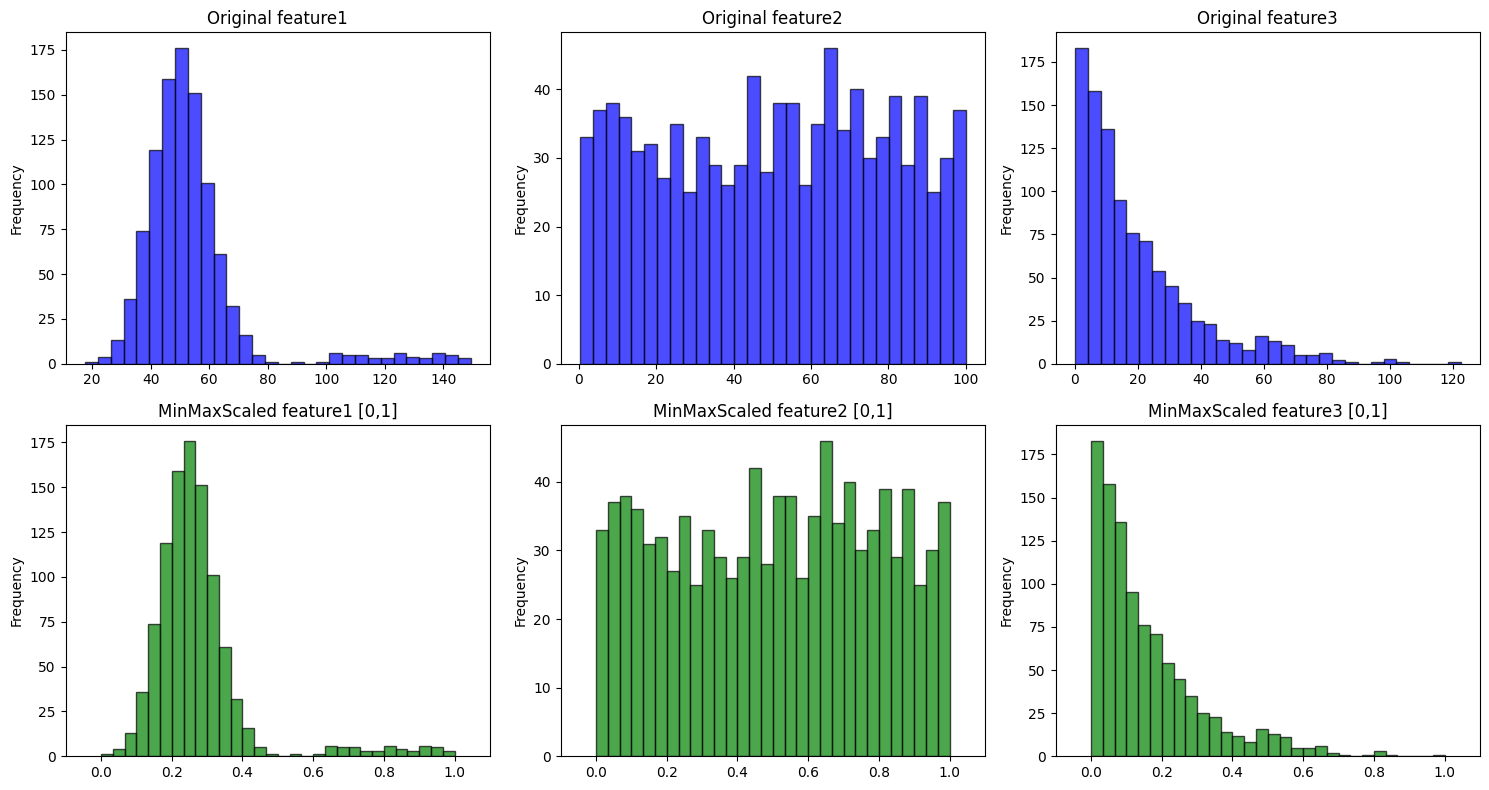

📝 Key observations:
- All values now between 0 and 1
- Distribution shape preserved
- Outliers get squeezed to the extremes
- Relative distances between points maintained


In [10]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Plot original and scaled versions
for idx, col in enumerate(data_mm.columns):
    # Original
    axes[0, idx].hist(data_mm[col], bins=30, alpha=0.7, color='blue', edgecolor='black')
    axes[0, idx].set_title(f'Original {col}')
    axes[0, idx].set_ylabel('Frequency')
    
    # MinMax scaled
    axes[1, idx].hist(scaled_01_df[col], bins=30, alpha=0.7, color='green', edgecolor='black')
    axes[1, idx].set_title(f'MinMaxScaled {col} [0,1]')
    axes[1, idx].set_ylabel('Frequency')
    axes[1, idx].set_xlim(-0.1, 1.1)

plt.tight_layout()
plt.show()

print("📝 Key observations:")
print("- All values now between 0 and 1")
print("- Distribution shape preserved")
print("- Outliers get squeezed to the extremes")
print("- Relative distances between points maintained")

### MinMaxScaler with New Data (Production Warning!)

Here's a critical issue that happens in production:

In [11]:
# Train MinMaxScaler on training data
train_data = np.array([[1, 2], [2, 4], [3, 6], [4, 8], [5, 10]])
scaler = MinMaxScaler()
scaler.fit(train_data)

print("Training data range:")
print(f"Feature 1: [{train_data[:, 0].min()}, {train_data[:, 0].max()}]")
print(f"Feature 2: [{train_data[:, 1].min()}, {train_data[:, 1].max()}]")

# New data with values outside training range
new_data = np.array([[0, 0], [6, 12], [10, 20]])  # Outside original range!
scaled_new = scaler.transform(new_data)

print("\n⚠️ WARNING: New data with out-of-range values:")
print("Original new data:", new_data)
print("Scaled new data:", scaled_new)
print("\n❌ Values outside [0,1] range! This breaks assumptions!")

# Solution: Clip values or retrain periodically
scaled_new_clipped = np.clip(scaled_new, 0, 1)
print("\n✅ Solution - Clipped values:", scaled_new_clipped)

Training data range:
Feature 1: [1, 5]
Feature 2: [2, 10]

⚠️ WARNING: New data with out-of-range values:
Original new data: [[ 0  0]
 [ 6 12]
 [10 20]]
Scaled new data: [[-0.25 -0.25]
 [ 1.25  1.25]
 [ 2.25  2.25]]

❌ Values outside [0,1] range! This breaks assumptions!

✅ Solution - Clipped values: [[0. 0.]
 [1. 1.]
 [1. 1.]]


### When to Use MinMaxScaler

**Use MinMaxScaler when:**
- You need features in a specific range (e.g., neural networks often expect [0,1])
- Your data has a bounded range
- You know the approximate min/max from domain knowledge
- Working with image data (pixel values)

**Don't use when:**
- Your data has significant outliers (they'll compress the "normal" values)
- New data might have values outside the training range
- You need robust handling of outliers (use RobustScaler)

## 4. RobustScaler (Outlier-Resistant Scaling)

### How RobustScaler Works

RobustScaler uses statistics that are robust to outliers:
- Centers using the **median** (instead of mean)
- Scales using the **interquartile range (IQR)** (instead of standard deviation)

Formula: `x_scaled = (x - median) / IQR`

This makes it perfect for data with outliers!

In [12]:
# Create data with significant outliers
np.random.seed(42)
n_samples = 1000

# Normal data with outliers added
normal_data = np.random.normal(100, 15, n_samples - 50)
outliers = np.random.uniform(200, 500, 50)  # Extreme outliers
data_with_outliers = np.concatenate([normal_data, outliers])
np.random.shuffle(data_with_outliers)

df_outliers = pd.DataFrame({
    'with_outliers': data_with_outliers,
    'normal': np.random.normal(100, 15, n_samples)
})

print("Data statistics:")
print(df_outliers.describe())
print("\n📊 Notice the huge difference between mean and 50% (median) in 'with_outliers'")

Data statistics:
       with_outliers     normal
count      1000.0000  1000.0000
mean        112.4005   100.1984
std          58.2149    14.5494
min          51.3810    54.7073
25%          90.9952    90.3377
50%         101.1943   100.0130
75%         111.5244   110.0747
max         495.9988   147.8966

📊 Notice the huge difference between mean and 50% (median) in 'with_outliers'


### Comparing Scalers on Data with Outliers

Let's see how different scalers handle outliers:

In [13]:
from sklearn.preprocessing import RobustScaler

# Apply different scalers
standard_scaled = StandardScaler().fit_transform(df_outliers)
minmax_scaled = MinMaxScaler().fit_transform(df_outliers)
robust_scaled = RobustScaler().fit_transform(df_outliers)

# Create DataFrames for plotting
standard_df = pd.DataFrame(standard_scaled, columns=[f'{col}_standard' for col in df_outliers.columns])
minmax_df = pd.DataFrame(minmax_scaled, columns=[f'{col}_minmax' for col in df_outliers.columns])
robust_df = pd.DataFrame(robust_scaled, columns=[f'{col}_robust' for col in df_outliers.columns])

### Visualizing the Difference

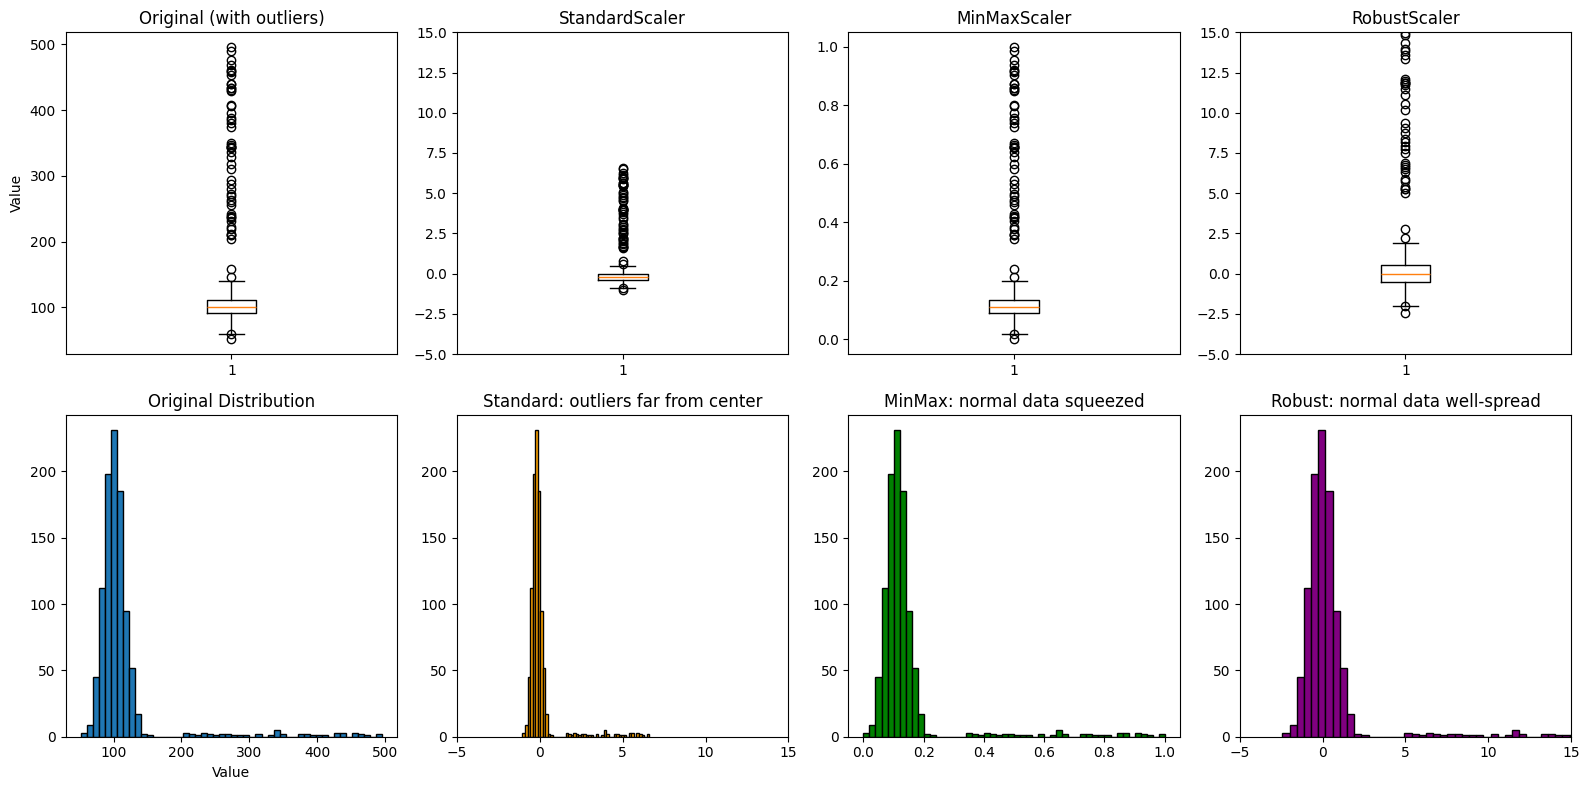

📝 Key insights:
- StandardScaler: outliers become extreme values (10+ std away)
- MinMaxScaler: squeezes normal data into small range
- RobustScaler: maintains good spread for normal data, outliers less extreme


In [14]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Plot 'with_outliers' column
col_idx = 0  # First column with outliers

# Original
axes[0, 0].boxplot(df_outliers.iloc[:, col_idx])
axes[0, 0].set_title('Original (with outliers)')
axes[0, 0].set_ylabel('Value')

# StandardScaler
axes[0, 1].boxplot(standard_df.iloc[:, col_idx])
axes[0, 1].set_title('StandardScaler')
axes[0, 1].set_ylim(-5, 15)

# MinMaxScaler
axes[0, 2].boxplot(minmax_df.iloc[:, col_idx])
axes[0, 2].set_title('MinMaxScaler')

# RobustScaler
axes[0, 3].boxplot(robust_df.iloc[:, col_idx])
axes[0, 3].set_title('RobustScaler')
axes[0, 3].set_ylim(-5, 15)

# Histograms for better view of distribution
axes[1, 0].hist(df_outliers.iloc[:, col_idx], bins=50, edgecolor='black')
axes[1, 0].set_title('Original Distribution')
axes[1, 0].set_xlabel('Value')

axes[1, 1].hist(standard_df.iloc[:, col_idx], bins=50, edgecolor='black', color='orange')
axes[1, 1].set_title('Standard: outliers far from center')
axes[1, 1].set_xlim(-5, 15)

axes[1, 2].hist(minmax_df.iloc[:, col_idx], bins=50, edgecolor='black', color='green')
axes[1, 2].set_title('MinMax: normal data squeezed')

axes[1, 3].hist(robust_df.iloc[:, col_idx], bins=50, edgecolor='black', color='purple')
axes[1, 3].set_title('Robust: normal data well-spread')
axes[1, 3].set_xlim(-5, 15)

plt.tight_layout()
plt.show()

print("📝 Key insights:")
print("- StandardScaler: outliers become extreme values (10+ std away)")
print("- MinMaxScaler: squeezes normal data into small range")
print("- RobustScaler: maintains good spread for normal data, outliers less extreme")

### RobustScaler in Practice

In [15]:
# Create a practical example with salary data
salary_data = pd.DataFrame({
    'years_experience': np.random.uniform(0, 30, 1000),
    'salary': np.concatenate([
        np.random.normal(60000, 15000, 950),  # Normal salaries
        np.random.uniform(500000, 1000000, 50)  # CEO salaries (outliers)
    ])
})

# Apply RobustScaler
robust_scaler = RobustScaler()
salary_scaled = robust_scaler.fit_transform(salary_data)

print("Original salary statistics:")
print(f"Mean: ${salary_data['salary'].mean():,.0f}")
print(f"Median: ${salary_data['salary'].median():,.0f}")
print(f"Min: ${salary_data['salary'].min():,.0f}")
print(f"Max: ${salary_data['salary'].max():,.0f}")

print("\nRobustScaler statistics:")
print(f"Median (center): {robust_scaler.center_[1]:,.0f}")
print(f"Scale (IQR): {robust_scaler.scale_[1]:,.0f}")

print("\n✅ RobustScaler uses median and IQR, ignoring extreme CEO salaries!")

Original salary statistics:
Mean: $93,126
Median: $60,469
Min: $14,886
Max: $988,228

RobustScaler statistics:
Median (center): 60,469
Scale (IQR): 21,720

✅ RobustScaler uses median and IQR, ignoring extreme CEO salaries!


### When to Use RobustScaler

**Use RobustScaler when:**
- Your data has outliers you can't or don't want to remove
- You need robust statistics
- Working with financial data (often has extreme values)
- Sensor data that might have anomalies

**Don't use when:**
- Outliers are actually important signals (not noise)
- You need exact range like [0,1]
- Your data is already clean and normally distributed

## 5. Normalizer (Row-wise Normalization)

### How Normalizer Works

Unlike other scalers that work **column-wise**, Normalizer works **row-wise**. It scales each sample (row) to have unit norm.

Common norms:
- **L2 norm** (default): Euclidean distance = 1
- **L1 norm**: Manhattan distance = 1
- **Max norm**: Maximum value = 1

This is useful when the magnitude of the sample doesn't matter, only the direction.

In [16]:
# Create sample data - document vectors (word counts)
documents = pd.DataFrame({
    'word1': [1, 5, 2, 0],
    'word2': [2, 0, 1, 3],
    'word3': [0, 3, 4, 1],
    'word4': [3, 2, 0, 2]
})

print("Original document vectors (word counts):")
print(documents)
print("\nDocument lengths (total words):")
print(documents.sum(axis=1).values)
print("\n📝 Documents have different lengths - comparing them directly is unfair!")

Original document vectors (word counts):
   word1  word2  word3  word4
0      1      2      0      3
1      5      0      3      2
2      2      1      4      0
3      0      3      1      2

Document lengths (total words):
[ 6 10  7  6]

📝 Documents have different lengths - comparing them directly is unfair!


### Applying Normalizer

In [17]:
from sklearn.preprocessing import Normalizer

# L2 normalization (default)
normalizer_l2 = Normalizer(norm='l2')
normalized_l2 = normalizer_l2.fit_transform(documents)

# L1 normalization
normalizer_l1 = Normalizer(norm='l1')
normalized_l1 = normalizer_l1.fit_transform(documents)

# Max normalization
normalizer_max = Normalizer(norm='max')
normalized_max = normalizer_max.fit_transform(documents)

print("L2 Normalized (Euclidean norm = 1):")
print(pd.DataFrame(normalized_l2, columns=documents.columns).round(3))
print("Row norms:", np.linalg.norm(normalized_l2, axis=1))

print("\nL1 Normalized (sum of absolute values = 1):")
print(pd.DataFrame(normalized_l1, columns=documents.columns).round(3))
print("Row sums:", np.sum(normalized_l1, axis=1))

print("\nMax Normalized (max value in each row = 1):")
print(pd.DataFrame(normalized_max, columns=documents.columns).round(3))
print("Row max values:", np.max(normalized_max, axis=1))

L2 Normalized (Euclidean norm = 1):
   word1  word2  word3  word4
0  0.267  0.535  0.000  0.802
1  0.811  0.000  0.487  0.324
2  0.436  0.218  0.873  0.000
3  0.000  0.802  0.267  0.535
Row norms: [1. 1. 1. 1.]

L1 Normalized (sum of absolute values = 1):
   word1  word2  word3  word4
0  0.167  0.333  0.000  0.500
1  0.500  0.000  0.300  0.200
2  0.286  0.143  0.571  0.000
3  0.000  0.500  0.167  0.333
Row sums: [1. 1. 1. 1.]

Max Normalized (max value in each row = 1):
   word1  word2  word3  word4
0  0.333  0.667  0.000  1.000
1  1.000  0.000  0.600  0.400
2  0.500  0.250  1.000  0.000
3  0.000  1.000  0.333  0.667
Row max values: [1. 1. 1. 1.]


### Practical Example: Comparing User Preferences

In [18]:
# User ratings for different movie genres (1-5 scale)
# But users rate differently - some are harsh, some generous
user_ratings = pd.DataFrame({
    'Action': [5, 2, 4, 1, 3],
    'Comedy': [3, 5, 2, 2, 4],
    'Drama': [4, 3, 5, 3, 2],
    'Horror': [1, 1, 3, 5, 1],
    'SciFi': [2, 4, 1, 4, 5]
}, index=[f'User_{i+1}' for i in range(5)])

print("Original ratings:")
print(user_ratings)
print("\nAverage rating per user:")
print(user_ratings.mean(axis=1))
print("\n📝 User_1 rates high, User_4 rates low - hard to compare preferences!")

# Normalize to compare preferences regardless of rating scale
normalized_ratings = Normalizer(norm='l2').fit_transform(user_ratings)
normalized_df = pd.DataFrame(normalized_ratings, 
                            columns=user_ratings.columns,
                            index=user_ratings.index)

print("\nNormalized preferences (now comparable):")
print(normalized_df.round(3))

# Find similar users
from sklearn.metrics.pairwise import cosine_similarity
similarity = cosine_similarity(normalized_ratings)
similarity_df = pd.DataFrame(similarity, 
                            index=user_ratings.index,
                            columns=user_ratings.index)

print("\nUser similarity matrix:")
print(similarity_df.round(3))
print("\n✅ Now we can find users with similar taste regardless of rating harshness!")

Original ratings:
        Action  Comedy  Drama  Horror  SciFi
User_1       5       3      4       1      2
User_2       2       5      3       1      4
User_3       4       2      5       3      1
User_4       1       2      3       5      4
User_5       3       4      2       1      5

Average rating per user:
User_1    3.0
User_2    3.0
User_3    3.0
User_4    3.0
User_5    3.0
dtype: float64

📝 User_1 rates high, User_4 rates low - hard to compare preferences!

Normalized preferences (now comparable):
        Action  Comedy  Drama  Horror  SciFi
User_1   0.674   0.405  0.539   0.135  0.270
User_2   0.270   0.674  0.405   0.135  0.539
User_3   0.539   0.270  0.674   0.405  0.135
User_4   0.135   0.270  0.405   0.674  0.539
User_5   0.405   0.539  0.270   0.135  0.674

User similarity matrix:
        User_1  User_2  User_3  User_4  User_5
User_1   1.000   0.836   0.927   0.655   0.836
User_2   0.836   1.000   0.727   0.764   0.964
User_3   0.927   0.727   1.000   0.764   0.691
User_4

### When to Use Normalizer

**Use Normalizer when:**
- Comparing samples of different magnitudes (text documents of different lengths)
- Direction matters more than magnitude (user preferences)
- Computing cosine similarity
- Working with word frequency vectors

**Don't use when:**
- Absolute values matter
- You need feature-wise (column) scaling
- Working with most traditional ML algorithms

## 6. Common Mistakes and How to Avoid Them

### Mistake 1: Scaling Before Split (Data Leakage!)

This is the most common and serious mistake:

In [19]:
# ❌ WRONG WAY - DON'T DO THIS!
print("❌ WRONG: Scaling before split causes data leakage!")

# Create sample data
X = np.random.randn(1000, 3)
y = np.random.randint(0, 2, 1000)

# Wrong: Scale BEFORE splitting
scaler_wrong = StandardScaler()
X_scaled_wrong = scaler_wrong.fit_transform(X)  # Fits on ALL data
X_train_wrong, X_test_wrong, y_train, y_test = train_test_split(
    X_scaled_wrong, y, test_size=0.2, random_state=42
)

print("Scaler learned from ALL data (including test set)!")
print(f"Mean used: {scaler_wrong.mean_}")

❌ WRONG: Scaling before split causes data leakage!
Scaler learned from ALL data (including test set)!
Mean used: [-0.04491651  0.01209941 -0.05958208]


In [20]:
# ✅ RIGHT WAY - DO THIS!
print("\n✅ CORRECT: Scale after split, fit only on training data!")

# Right: Split FIRST, then scale
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fit scaler ONLY on training data
scaler_right = StandardScaler()
X_train_scaled = scaler_right.fit_transform(X_train)  # Fit on train
X_test_scaled = scaler_right.transform(X_test)  # Only transform test

print("Scaler learned ONLY from training data!")
print(f"Mean used: {scaler_right.mean_}")
print("\n📝 The means are different! The right way prevents data leakage.")


✅ CORRECT: Scale after split, fit only on training data!
Scaler learned ONLY from training data!
Mean used: [-0.06540173  0.0219023  -0.07751333]

📝 The means are different! The right way prevents data leakage.


### Mistake 2: Forgetting to Scale New Production Data

In [21]:
# Simulate production scenario
print("Production Scenario:")
print("-" * 40)

# Train model with scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# ❌ WRONG: Forgetting to scale new data
new_data_wrong = np.random.randn(5, 3)  # New production data
print("❌ Wrong: Using unscaled new data")
print(f"New data range: [{new_data_wrong.min():.2f}, {new_data_wrong.max():.2f}]")
print(f"Training data range: [{X_train_scaled.min():.2f}, {X_train_scaled.max():.2f}]")
print("These are incompatible!\n")

# ✅ RIGHT: Transform new data with the same scaler
new_data_right = scaler.transform(new_data_wrong)
print("✅ Right: Scaling new data with saved scaler")
print(f"New data range: [{new_data_right.min():.2f}, {new_data_right.max():.2f}]")
print(f"Training data range: [{X_train_scaled.min():.2f}, {X_train_scaled.max():.2f}]")
print("Now they're compatible!")

Production Scenario:
----------------------------------------
❌ Wrong: Using unscaled new data
New data range: [-1.67, 2.71]
Training data range: [-2.97, 3.46]
These are incompatible!

✅ Right: Scaling new data with saved scaler
New data range: [-1.69, 2.67]
Training data range: [-2.97, 3.46]
Now they're compatible!


### Mistake 3: Not Saving Scaler for Production

In [22]:
import pickle
import joblib

# Train scaler
scaler = StandardScaler()
scaler.fit(X_train)

# ✅ RIGHT: Save the scaler
print("✅ Saving scaler for production:")

# Method 1: Using pickle
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("Saved with pickle: scaler.pkl")

# Method 2: Using joblib (more efficient for sklearn)
joblib.dump(scaler, 'scaler.joblib')
print("Saved with joblib: scaler.joblib")

# Load and use in production
loaded_scaler = joblib.load('scaler.joblib')
print(f"\nLoaded scaler mean: {loaded_scaler.mean_}")
print("Ready for production use!")

# Clean up files
import os
os.remove('scaler.pkl')
os.remove('scaler.joblib')

✅ Saving scaler for production:
Saved with pickle: scaler.pkl
Saved with joblib: scaler.joblib

Loaded scaler mean: [-0.06540173  0.0219023  -0.07751333]
Ready for production use!


## 7. Production Best Practices

### Building a Robust Scaling Pipeline

In [23]:
class RobustScalingPipeline:
    """Production-ready scaling pipeline with error handling"""
    
    def __init__(self, method='standard', clip_outliers=True):
        self.method = method
        self.clip_outliers = clip_outliers
        self.scaler = None
        self.feature_names = None
        self.is_fitted = False
        
    def fit(self, X, feature_names=None):
        """Fit the scaler with validation"""
        # Store feature names for validation
        if isinstance(X, pd.DataFrame):
            self.feature_names = X.columns.tolist()
            X_array = X.values
        else:
            self.feature_names = feature_names
            X_array = X
            
        # Choose scaler
        if self.method == 'standard':
            self.scaler = StandardScaler()
        elif self.method == 'minmax':
            self.scaler = MinMaxScaler()
        elif self.method == 'robust':
            self.scaler = RobustScaler()
        else:
            raise ValueError(f"Unknown method: {self.method}")
            
        # Fit scaler
        self.scaler.fit(X_array)
        self.is_fitted = True
        
        # Store statistics for monitoring
        self.training_stats = {
            'mean': np.mean(X_array, axis=0),
            'std': np.std(X_array, axis=0),
            'min': np.min(X_array, axis=0),
            'max': np.max(X_array, axis=0)
        }
        
        return self
        
    def transform(self, X):
        """Transform with validation and monitoring"""
        if not self.is_fitted:
            raise ValueError("Pipeline not fitted! Call fit() first.")
            
        # Validate feature names if DataFrame
        if isinstance(X, pd.DataFrame):
            if self.feature_names and list(X.columns) != self.feature_names:
                raise ValueError(f"Feature mismatch! Expected {self.feature_names}")
            X_array = X.values
        else:
            X_array = X
            
        # Check for anomalies
        self._check_anomalies(X_array)
        
        # Transform
        X_scaled = self.scaler.transform(X_array)
        
        # Clip if requested (for MinMaxScaler)
        if self.clip_outliers and self.method == 'minmax':
            X_scaled = np.clip(X_scaled, 0, 1)
            
        return X_scaled
        
    def _check_anomalies(self, X):
        """Check for unusual values in new data"""
        new_stats = {
            'mean': np.mean(X, axis=0),
            'std': np.std(X, axis=0),
            'min': np.min(X, axis=0),
            'max': np.max(X, axis=0)
        }
        
        # Check if new data is very different from training
        mean_shift = np.abs(new_stats['mean'] - self.training_stats['mean'])
        if np.any(mean_shift > 3 * self.training_stats['std']):
            print("⚠️ WARNING: Significant distribution shift detected!")
            print(f"Features with large shifts: {np.where(mean_shift > 3 * self.training_stats['std'])[0]}")

# Test the pipeline
pipeline = RobustScalingPipeline(method='standard')
pipeline.fit(X_train)

# Normal data - no warning
X_test_normal = X_test
X_test_scaled = pipeline.transform(X_test_normal)
print("Normal test data: No warnings")

# Anomalous data - should trigger warning
X_test_anomaly = X_test * 10 + 100
print("\nAnomalous test data:")
X_test_anomaly_scaled = pipeline.transform(X_test_anomaly)

Normal test data: No warnings

Anomalous test data:
⚠️ WARNING: Significant distribution shift detected!
Features with large shifts: [0 1 2]


## Practice Exercises

### Exercise 1: Choose and Apply the Right Scaler

Given different datasets, choose and apply the appropriate scaler:

In [24]:
# Dataset 1: Customer ages and incomes (with millionaire outliers)
exercise1_data = pd.DataFrame({
    'age': np.random.uniform(18, 80, 1000),
    'income': np.concatenate([
        np.random.normal(50000, 15000, 980),
        np.random.uniform(1000000, 10000000, 20)  # Millionaires
    ])
})

# Your task: Choose and apply appropriate scaler
# Explain your choice!

# Your code here:


### Exercise 2: Build a Complete Scaling Pipeline

Create a function that automatically chooses the best scaler based on data characteristics:

In [25]:
def auto_scale(X, check_outliers=True, check_distribution=True):
    """
    Automatically choose and apply best scaler based on data.
    
    Parameters:
    X: Data to scale
    check_outliers: Whether to check for outliers
    check_distribution: Whether to check distribution shape
    
    Returns:
    Scaled data and scaler used
    """
    # Your implementation here:
    # 1. Check for outliers using IQR
    # 2. Check if data is normally distributed
    # 3. Choose appropriate scaler
    # 4. Return scaled data and scaler name
    pass


## Key Takeaways

### Critical Points to Remember:

1. **Different algorithms have different scaling needs**
   - Distance-based (KNN, SVM): Always scale
   - Tree-based (Random Forest, XGBoost): Usually don't need scaling
   - Neural Networks: Almost always need scaling to [0,1] or [-1,1]

2. **Choose scaler based on your data**
   - Normal distribution → StandardScaler
   - Need specific range → MinMaxScaler
   - Outliers present → RobustScaler
   - Comparing samples → Normalizer

3. **Avoid data leakage**
   - ALWAYS split first, then scale
   - Fit scaler ONLY on training data
   - Transform both train and test with same scaler

4. **Production considerations**
   - Save your scaler with your model
   - Monitor for distribution shifts
   - Handle out-of-range values gracefully
   - Document scaling choices

5. **Common pitfalls**
   - Forgetting to scale test data
   - Scaling before splitting (data leakage)
   - Not saving scaler for production
   - Using wrong scaler for your algorithm

### Quick Reference Guide:

```python
# Standard workflow
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 1. Split first
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# 2. Create and fit scaler on training data
scaler = StandardScaler()  # or MinMaxScaler(), RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)

# 3. Transform test data
X_test_scaled = scaler.transform(X_test)

# 4. Save for production
import joblib
joblib.dump(scaler, 'scaler.joblib')
```

### Next Steps:
- Practice with your own datasets
- Experiment with different scalers on the same data
- Build scaling into your ML pipelines
- Monitor scaling in production systems

Remember: Proper scaling can make the difference between a model that fails and one that excels!